In [187]:
# Importamos los paquetes necesarios
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

import numpy as np
import os
import seaborn as sns
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from pandas.plotting import scatter_matrix

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"


from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from zlib import crc32
import hashlib
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from six.moves import urllib
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import (TimeSeriesSplit, KFold, ShuffleSplit,
StratifiedKFold, GroupShuffleSplit,
GroupKFold, StratifiedShuffleSplit,cross_val_score)
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import (OrdinalEncoder,OneHotEncoder)

# Donde guardar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Cargamos los datos y miramos las 5 primeras entradas

In [188]:
housing = pd.read_csv("data/housing.csv");
housing.head();

# Exploración de los datos

La base de datos cuenta con 10 variables, donde 9 seran features predictoras y "median_house_value" será la variable target.

In [189]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [190]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

Con gráficos de violin observamos la distribución de las features. Observamos que 'longitude' y 'latitude' presentan una distribución bimodal. A su vez observamos que 'total_rooms', 'total_bedrooms', 'population', 'households', están sesgadas a derecha y 'median_income', 'median_house_value' tienen un grado menor de sesgo también a derecha.

Saving figure violins_all


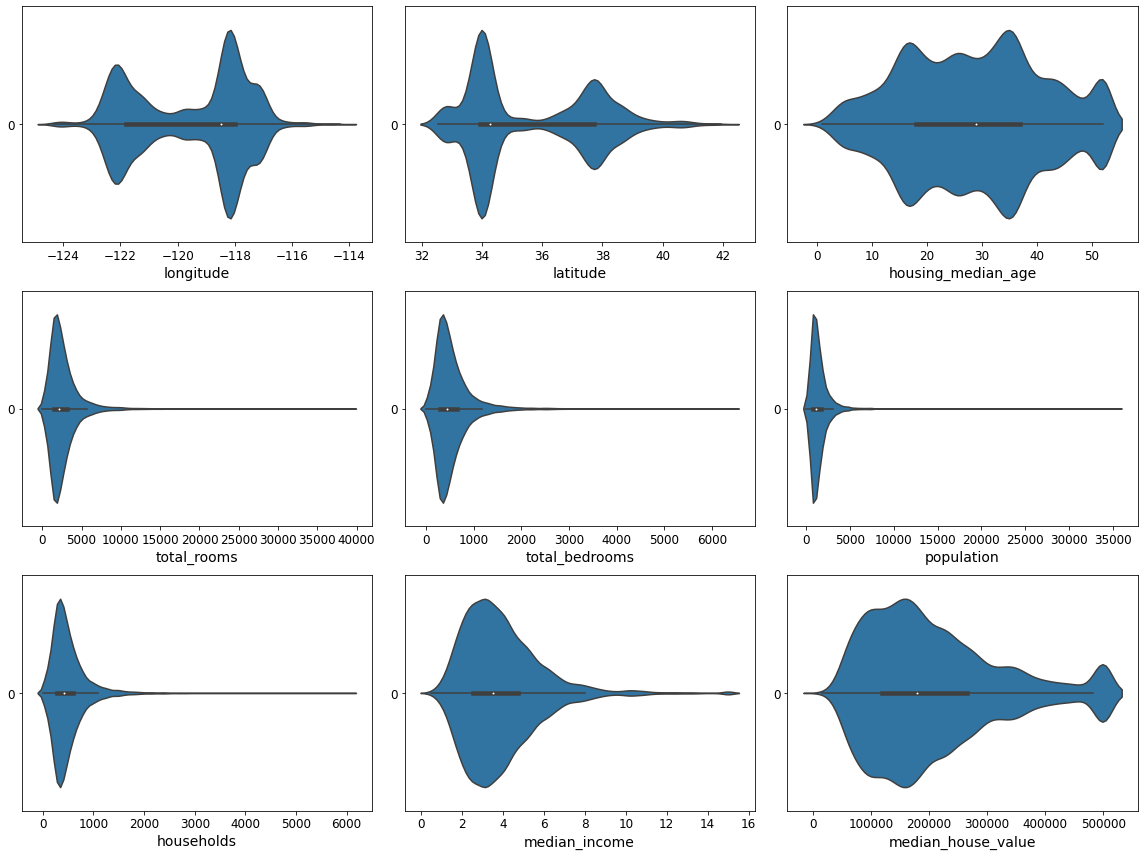

In [191]:
colnames = housing.columns
fig = plt.figure(figsize=(16,12))
for i in range(1, 10):
    ax = plt.subplot(3, 3, i)
    ax.set_xlabel(colnames[i-1])
    sns.violinplot(data=housing.iloc[:,i-1], orient= "h")
save_fig("violins_all")

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

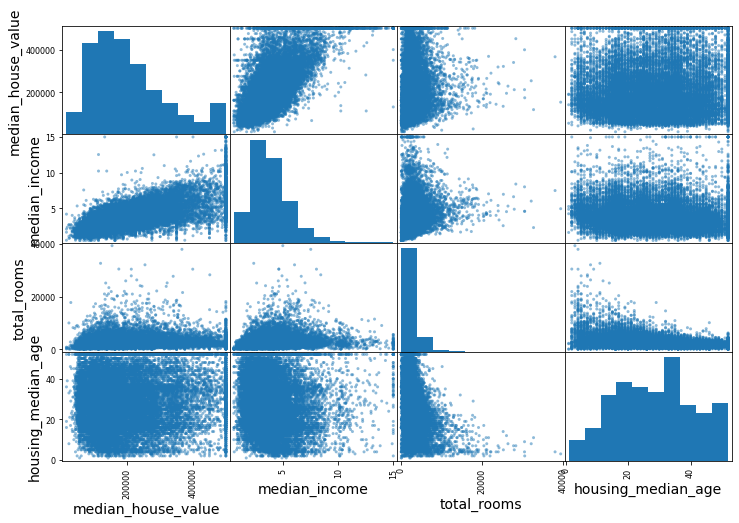

In [192]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

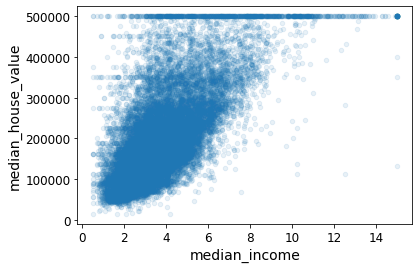

In [193]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

La tabla cuenta con datos de 20640 distritos. Como se puede obsevar en la tabla que sigue, la variable 'total_bedrooms' posee 207 datos faltantes.

In [194]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Discretizamos la variable median_income en 5 categorías. Vemos que las proporciones categorías no son uniformes.

In [195]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f0f33f38640>)

El grafico de la figura X presenta la distribución geográfica de la mediana del valor de las casas por distrito en California. Donde el tamaño de punto es proporcional al tamaño de la población en ese distrito y el color del punto indica el valor de la variable target median_house_value. Se puede observar que las regiones de San Francisco y Los Angeles concentran la mayor cantidad de puntos rojos correspondientes a valores de mediana más elevados por distrito.

Saving figure california_housing_prices_plot


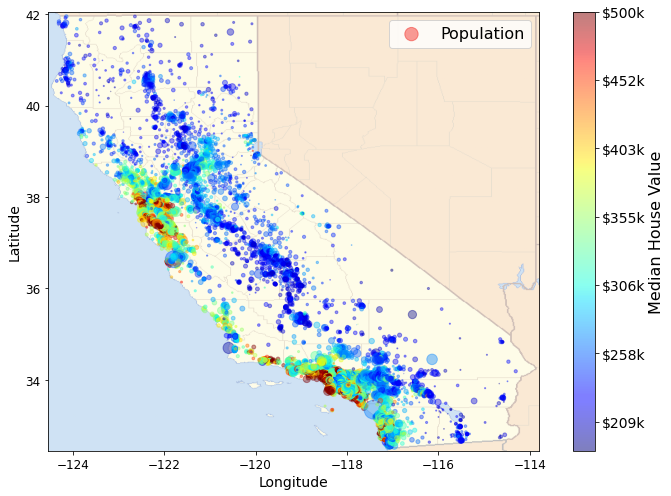

In [196]:

california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

En la figura X2 se pueden observar los valores de la matriz de correlación entre las variables. Vemos que las variables 'total_rooms', 'total_bedrooms', 'population' y 'households', presentan valores de corelación cercanos a uno, por tanto dichas covariables seran transformadas de manera de resumir la informacion concentrada en ellas tal como se verá en la sección XXX.

Saving figure correlations_housing_all


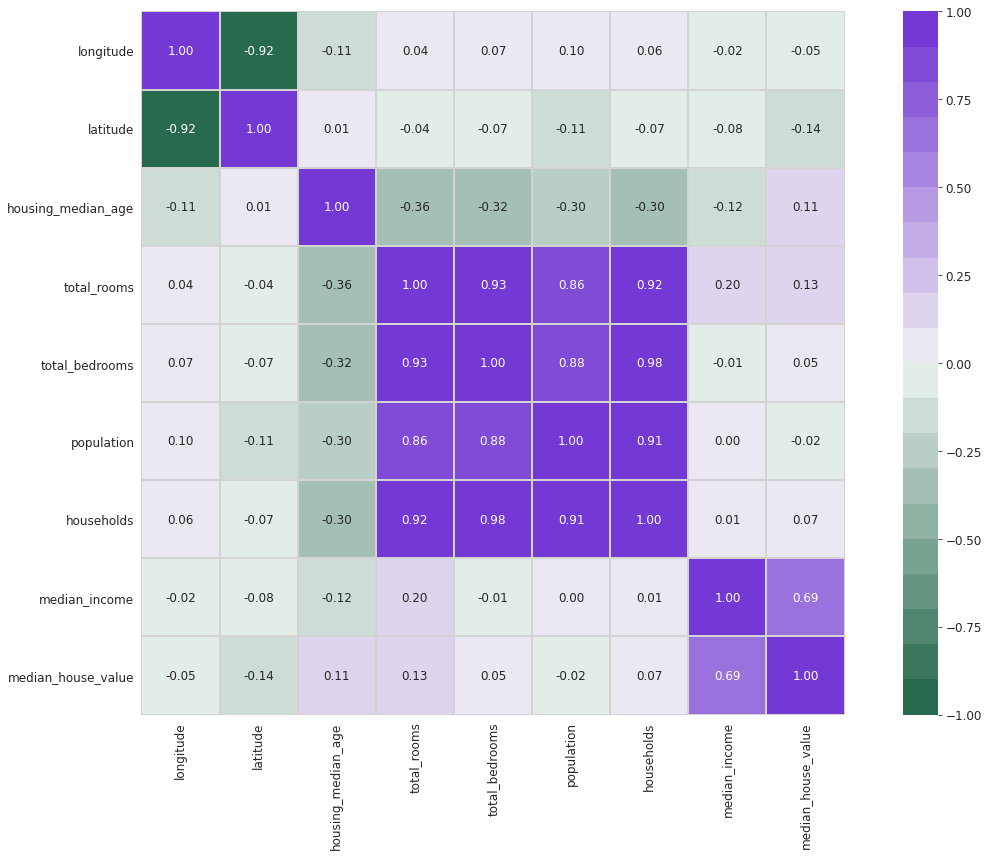

In [197]:
# Correlación entre variables preprocesamiento
corr_matrix = housing.corr()

paleta = sns.diverging_palette(150, 275, s=80, l=40, n=20)

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(17, 12))
    ax = sns.heatmap(corr_matrix,
                     annot=True,
                     annot_kws={'size': 12},
                     fmt='.2f',
                     vmax=1, 
                     vmin=-1, 
                     square=True, 
                     linewidths=.01, 
                     linecolor='lightgray', 
                     cmap=paleta)
save_fig("correlations_housing_all")

## Remover outliers

In [198]:
housing = housing[(housing['ocean_proximity'] != 'ISLAND')]

In [199]:
lof = LocalOutlierFactor(contamination=0.2)

#primero saco los nans
dataSet_withoutnan = housing[housing['median_house_value']<500000].dropna().copy()

#selecciono los atributos sobre los cuales voy a estudiar la presencia de outliers
names = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
housingForOutliers = dataSet_withoutnan[names].copy()

#predicción de outliers
InOrOut = lof.fit_predict(housingForOutliers)

mask = InOrOut != -1
mask_series = pd.Series(mask)
print(np.unique(mask, return_counts=True))

#filtrado de los outliers
housing_filtered = dataSet_withoutnan[mask_series.values].copy()
data_for_split = housing_filtered.reset_index(drop=True).copy()

(array([False,  True]), array([ 3889, 15554]))


Saving figure violins_without_outliers


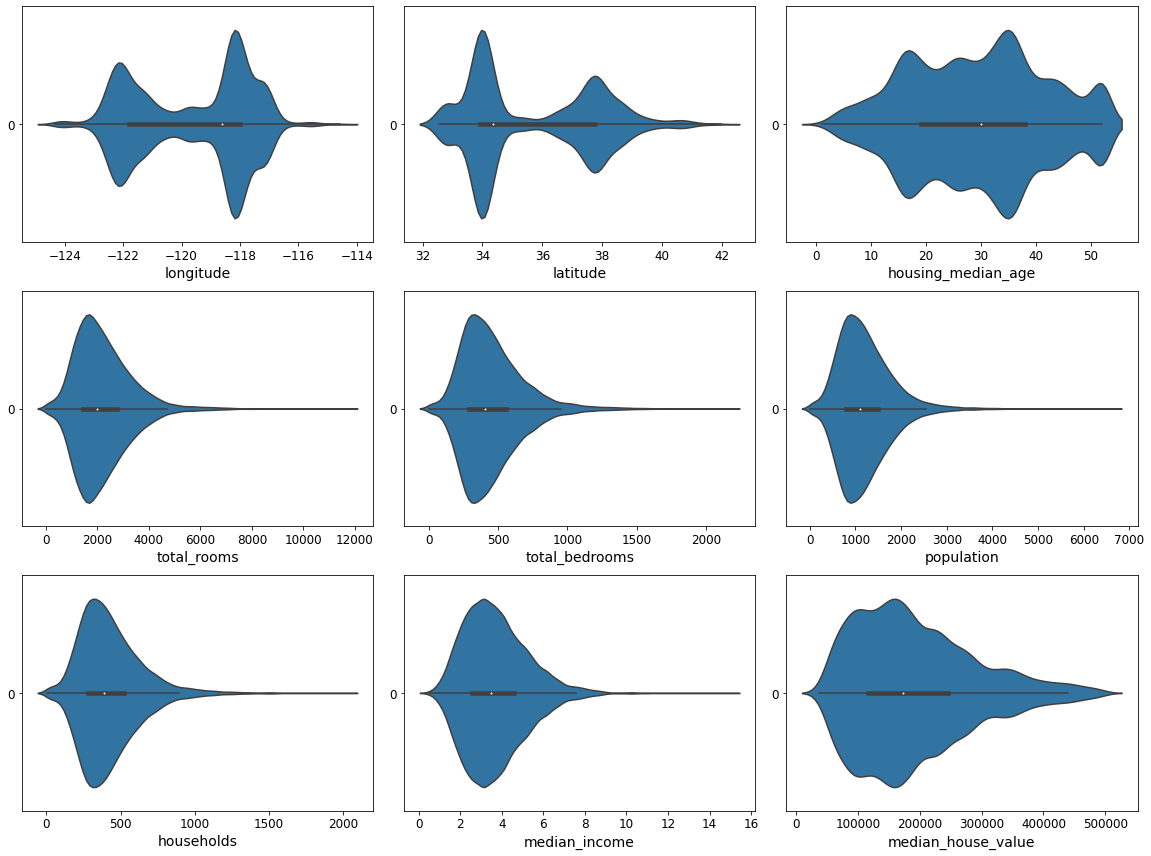

In [200]:
colnames = data_for_split.columns
fig = plt.figure(figsize=(16,12))
for i in range(1, 10):
    ax = plt.subplot(3, 3, i)
    ax.set_xlabel(colnames[i-1])
    sns.violinplot(data=data_for_split.iloc[:,i-1], orient= "h")
save_fig("violins_without_outliers")

# **Metodología**

## Separación en sets de train y test

Empleamos la estrategia de muestreo estratificado utilizando la variable median_income, para no incluir un sesgo en el muestreo. Dividimos las observaciones en subgrupos homogéneos respetando la distribución que presenta el gráfico de la figura X3. Este método garantiza que tanto el set de test y de train sean representativos de toda la población.

Saving figure income_cat


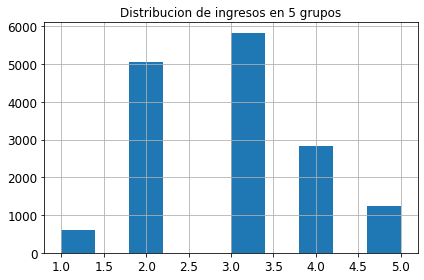

In [201]:
data_for_split["income_cat"] = pd.cut(data_for_split["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
data_for_split["income_cat"].hist()
plt.title("Distribucion de ingresos en 5 grupos")
save_fig("income_cat")

Comparamos las proporciones de la variable income_cat entre el data set completo, el set de testing resultado de un muestreo aleatorio y un muestreo estratificado. Vemos que el muestreo estratificado representa mejor las proporciones originales del set completo, por lo tanto elegimos este para realizar la división de datos.

In [202]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=30)
for train_index, test_index in split.split(data_for_split, data_for_split["income_cat"]):
    strat_train_set = data_for_split.loc[train_index]
    strat_test_set = data_for_split.loc[test_index]
    
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(data_for_split, test_size=0.2, random_state=6)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(data_for_split),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.038254,0.038251,0.038573,0.833853,-0.006429
2,0.325254,0.325297,0.315011,-3.149140,0.013337
3,0.373987,0.373835,0.384121,2.709573,-0.040809
4,0.182268,0.182257,0.175185,-3.886250,-0.006429
5,0.080237,0.080360,0.087110,8.566738,0.153817


In [203]:
strat_train_set['ocean_proximity'].value_counts()

<1H OCEAN     5381
INLAND        4101
NEAR OCEAN    1583
NEAR BAY      1378
Name: ocean_proximity, dtype: int64

In [204]:
strat_test_set['ocean_proximity'].value_counts()

<1H OCEAN     1355
INLAND         979
NEAR OCEAN     421
NEAR BAY       356
Name: ocean_proximity, dtype: int64

## Procesamiento y limpieza de datos

In [205]:
#sacamos la variable income_cat dado que sólo fue utilizada para dividir estratificadamente el data set
strat_train_set = strat_train_set.drop("income_cat", axis=1)

strat_test_set = strat_test_set.drop("income_cat", axis=1)

Para la preparación de datos seguimos los siguientes pasos: 
* Limpieza de datos faltantes
* Estandarización de covariables numéricas excepto 'longitude' y 'latitude'
* Transformacion de variables 'total_rooms', 'total_bedrooms', 'population' y 'households' en rooms_per_household, population_per_household, bedrooms_per_room
* Transformación de la variable categorica mediante la funcion _oneHotEncoder()_ generando cinco variables numericas binarias (una por cada categoria).

Este pipeline de procesamiento fue aplicado tanto al set de train como al set de test.

In [206]:
#esto lo hacemos para que el pipeline funcione correctamente. Simplemente transforma el dataset en un ndArray
#para que luego pueda utilizarlo la transformacion con CombinedAttributesAdder
class ConvertToNDArray(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        return X.values

convert_toNdArray = ConvertToNDArray()

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True,rooms_ix=2, bedrooms_ix=3, population_ix=4, households_ix=5): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        self.rooms_ix = rooms_ix 
        self.bedrooms_ix=bedrooms_ix 
        self.population_ix=population_ix 
        self.households_ix=households_ix
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, self.rooms_ix] / X[:, self.households_ix]
        population_per_household = X[:, self.population_ix] / X[:, self.households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, self.bedrooms_ix] / X[:, self.rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            result = np.c_[X, rooms_per_household, population_per_household]
            return result


In [207]:
def processingData(dataSet, targetFeature, categoricalFeature, col_names, extra_attribs):
        #quitamos los nan
     #  dataSet_withoutnan = dataSet.dropna().copy()
        
        #dividimos el dataset en las variables que se usan en la prediccion y la variable a predecir
        data = dataSet.drop(targetFeature, axis=1).copy() # drop labels for training set
        data_labels = dataSet[targetFeature].copy()
        
        #procesamos primero los datos numericos
        print("procesando los datos numericos...\n")
        numerical_data = data.drop([categoricalFeature, "longitude", "latitude"], axis=1).copy()
        
        #obtenemos los indices de las columnas que luego vamos a combinar
        rooms_ix, bedrooms_ix, population_ix, households_ix = [
            data.columns.get_loc(c) for c in col_names] # get the column indices
        
        #generamos el dataframe con los atributos extra
        attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
        data_extra_attribs = attr_adder.transform(data.values)
        data_extra = pd.DataFrame(
            data_extra_attribs,
            columns=list(data.columns)+extra_attribs,
            index=data.index).copy()
            
        num_pipeline = Pipeline([
        ('convert_toNdArray', ConvertToNDArray()),
        ('attribs_adder', CombinedAttributesAdder()),
        ('robust_scaler', RobustScaler()),
        ])

        #procesamos los datos categoricos
        print("procensando variables categoricas...\n")
        cat_attribs = [categoricalFeature]

        full_pipeline = ColumnTransformer([
                ("num", num_pipeline, list(numerical_data)),
                ("cat", OneHotEncoder(), cat_attribs),
            ])

        data_prepared = full_pipeline.fit_transform(data_extra.iloc[:, 2:])
        
        #devolvemos los datos procesados y los objetivos
        print("procesamiento finalizado :D")
        return data_prepared, data_labels, data_extra

In [208]:
train, train_labels, data_processed = processingData(strat_train_set, "median_house_value", 
                "ocean_proximity", 
                ["total_rooms", "total_bedrooms", "population", "households"], 
                ["rooms_per_household", "population_per_household","bedrooms_per_room"]);

procesando los datos numericos...

procensando variables categoricas...

procesamiento finalizado :D


In [209]:
test, test_labels, data_processed_test = processingData(strat_test_set, "median_house_value", 
                "ocean_proximity", 
                ["total_rooms", "total_bedrooms", "population", "households"], 
                ["rooms_per_household", "population_per_household","bedrooms_per_room"]);

procesando los datos numericos...

procensando variables categoricas...

procesamiento finalizado :D


In [210]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
Name: ocean_proximity, dtype: int64

In [211]:
data_processed['ocean_proximity'].value_counts()

<1H OCEAN     5381
INLAND        4101
NEAR OCEAN    1583
NEAR BAY      1378
Name: ocean_proximity, dtype: int64

In [212]:
data_processed_test['ocean_proximity'].value_counts()

<1H OCEAN     1355
INLAND         979
NEAR OCEAN     421
NEAR BAY       356
Name: ocean_proximity, dtype: int64

In [213]:
def correlationPostTransform(data_prepared, df_extra_attr, split):
    combined_data = np.c_[df_extra_attr.iloc[:, 0:2], data_prepared].copy() 

    names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
           'total_bedrooms', 'population', 'households', 'median_income',
            'rooms_per_household','population_per_household', 'bedrooms_per_room']#11    

    data_corr = pd.DataFrame(
        combined_data,
        columns=list(names)+["0", "1", "2", "3"],#+5
        index=df_extra_attr.index).astype(float).copy()
    
    attributes = ['housing_median_age', 'total_rooms',
           'total_bedrooms', 'population', 'households', 'median_income',
            'rooms_per_household','population_per_household', 'bedrooms_per_room']
    
    axes = scatter_matrix(data_corr[attributes], alpha=0.2, hist_kwds={'bins':30}, figsize=(12,8))
    for ax in axes.flatten():
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.label.set_ha('right')
    plt.gcf().subplots_adjust(wspace=0, hspace=0)
    save_fig("scatter_paired_"+split)
    plt.show()
    
    corr_matrix_pr = data_corr.corr()
    paleta = sns.diverging_palette(150, 275, s=80, l=40, n=20)
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(17, 12))
        ax = sns.heatmap(corr_matrix_pr,
                         annot=True,
                         annot_kws={'size': 12},
                         fmt='.2f',
                         vmax=1, 
                         vmin=-1, 
                         square=True, 
                         linewidths=.01, 
                         linecolor='lightgray', 
                         cmap=paleta)
        save_fig("correlation_transf_"+split)
    return combined_data, data_corr

El resultado de la estandarización de todas las variables numericas incluyendo las variables transformadas, exceptuando 'lonlitude' y 'latitude' de las variables arroja una matriz de correlacion como se observa en la figura X4. En función a las regiones de mayor correlación entre variables decidimos eliminar las variables 'total_bedrooms', 'population', 'households' y 'rooms_per_household para los análisis posteriores.

Saving figure scatter_paired_train


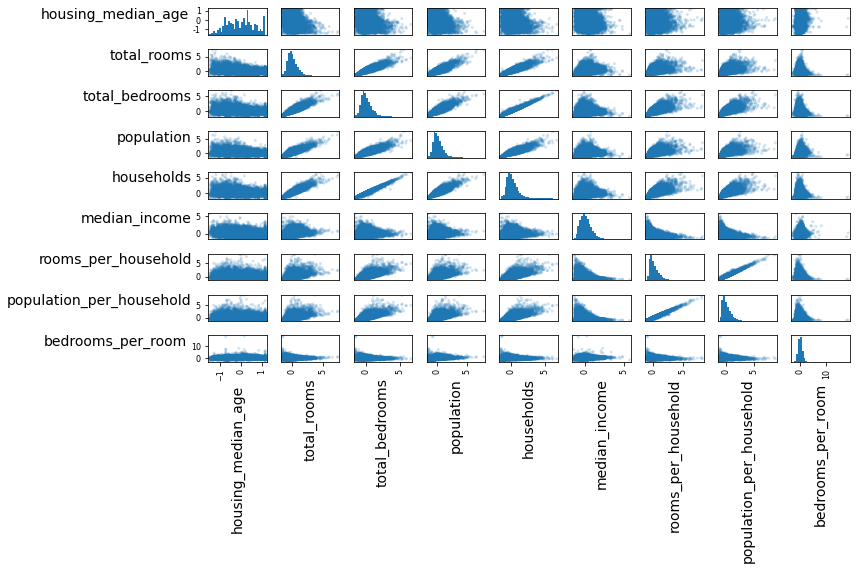

Saving figure correlation_transf_train


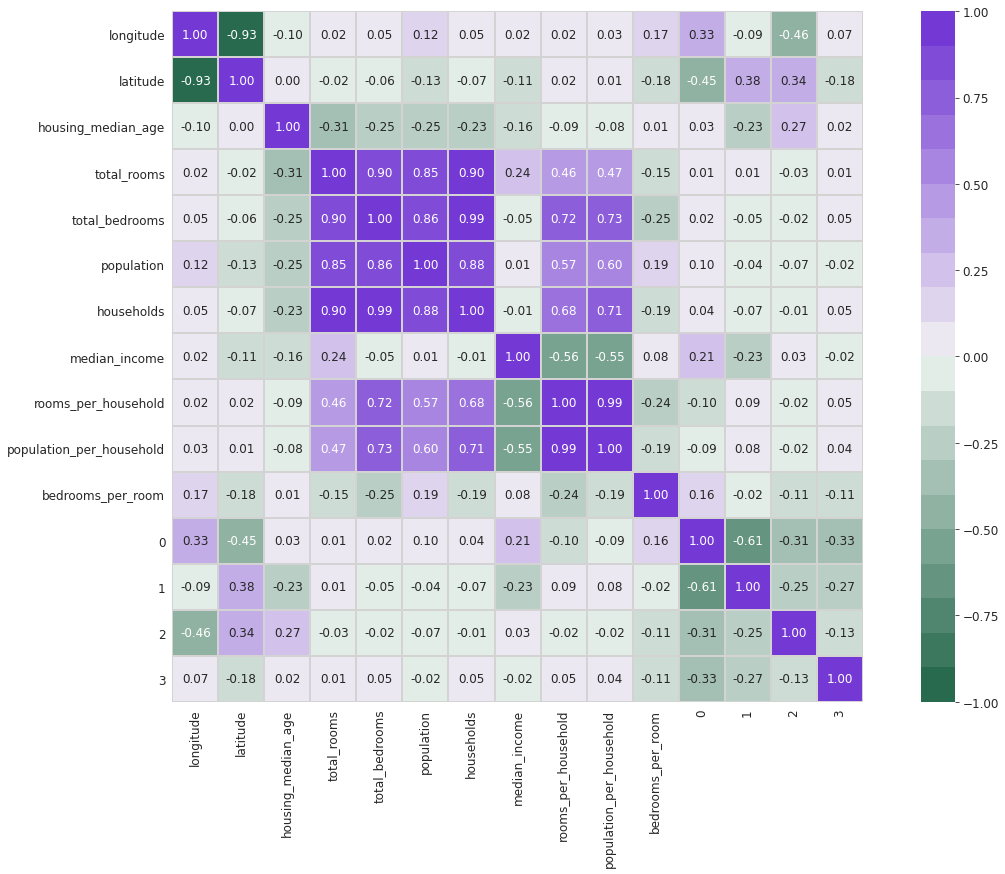

In [214]:
train_transf, data_train_transf = correlationPostTransform(train,data_processed,'train');

Saving figure scatter_paired_test


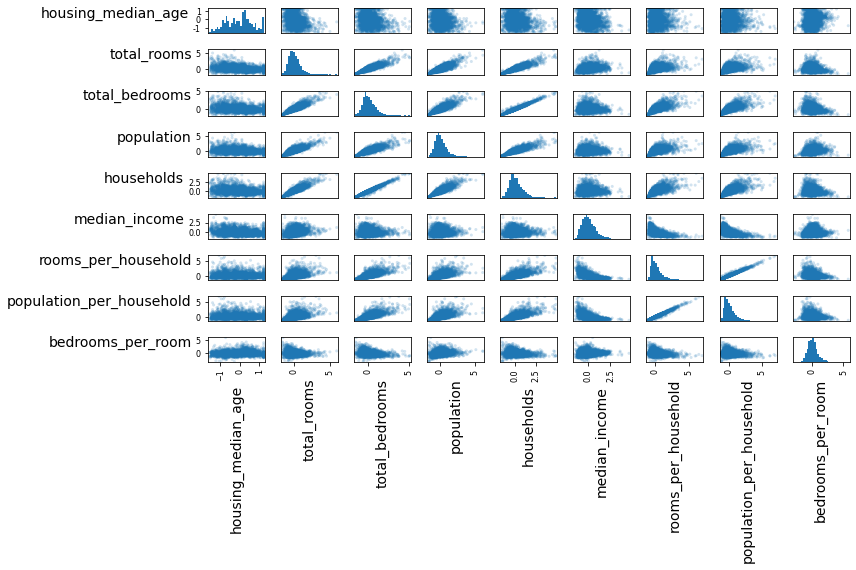

Saving figure correlation_transf_test


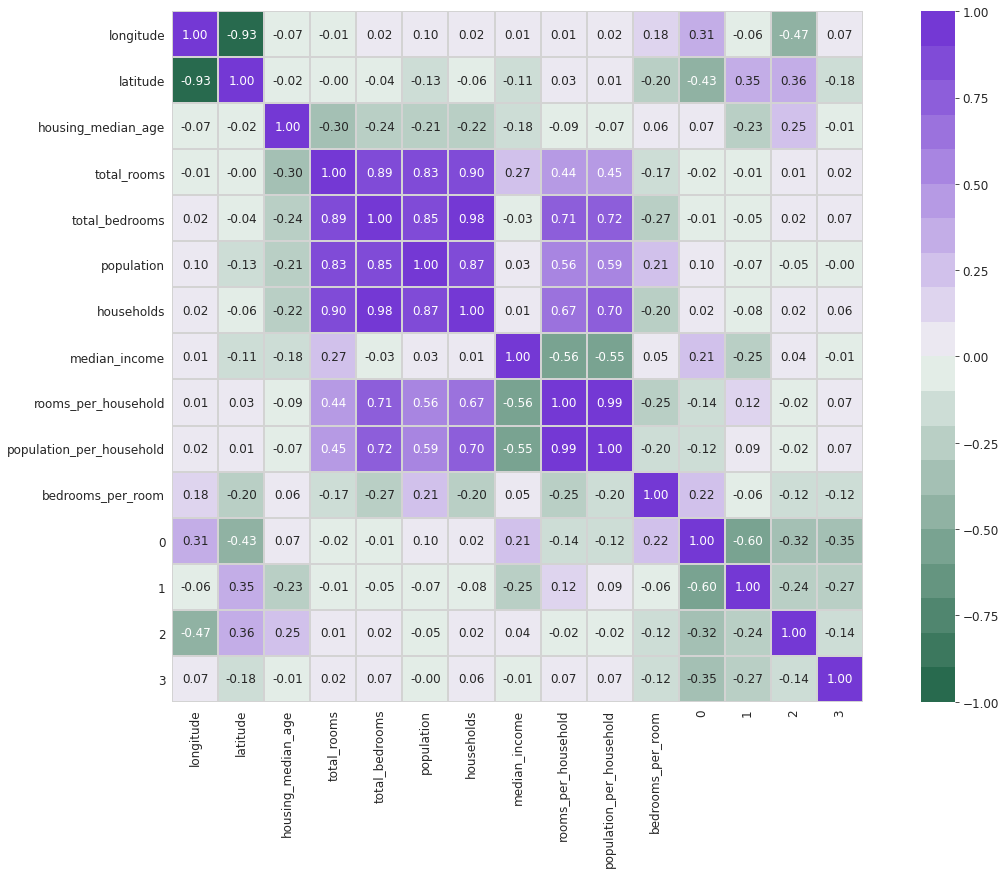

In [215]:
test_transf, data_test_transf = correlationPostTransform(test,data_processed_test,'test');

In [216]:
def finalizacionDeProcesamiento_notTransf(data_prepared, df_extra_attr, split):
    combined_data=np.c_[df_extra_attr.iloc[:, 0:2], data_prepared].copy() 

    names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
           'total_bedrooms', 'population', 'households', 'median_income',
            'rooms_per_household','population_per_household', 'bedrooms_per_room']

    namesToDrop = ['rooms_per_household', 'bedrooms_per_room', 'population_per_household']


    data_corr = pd.DataFrame(
        combined_data,
        columns=list(names)+["0", "1", "2", "3"],#, "4"],
        index=df_extra_attr.index).astype(float).drop(namesToDrop, axis=1).copy()

    corr_matrix_pr = data_corr.corr()
    paleta = sns.diverging_palette(150, 275, s=80, l=40, n=20)
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(17, 12))
        ax = sns.heatmap(corr_matrix_pr,
                         annot=True,
                         annot_kws={'size': 12},
                         fmt='.2f',
                         vmax=1, 
                         vmin=-1, 
                         square=True, 
                         linewidths=.01, 
                         linecolor='lightgray', 
                         cmap=paleta)
        save_fig("correlation_original_"+split)
    return combined_data, data_corr

Saving figure correlation_original_train
Saving figure correlation_original_test


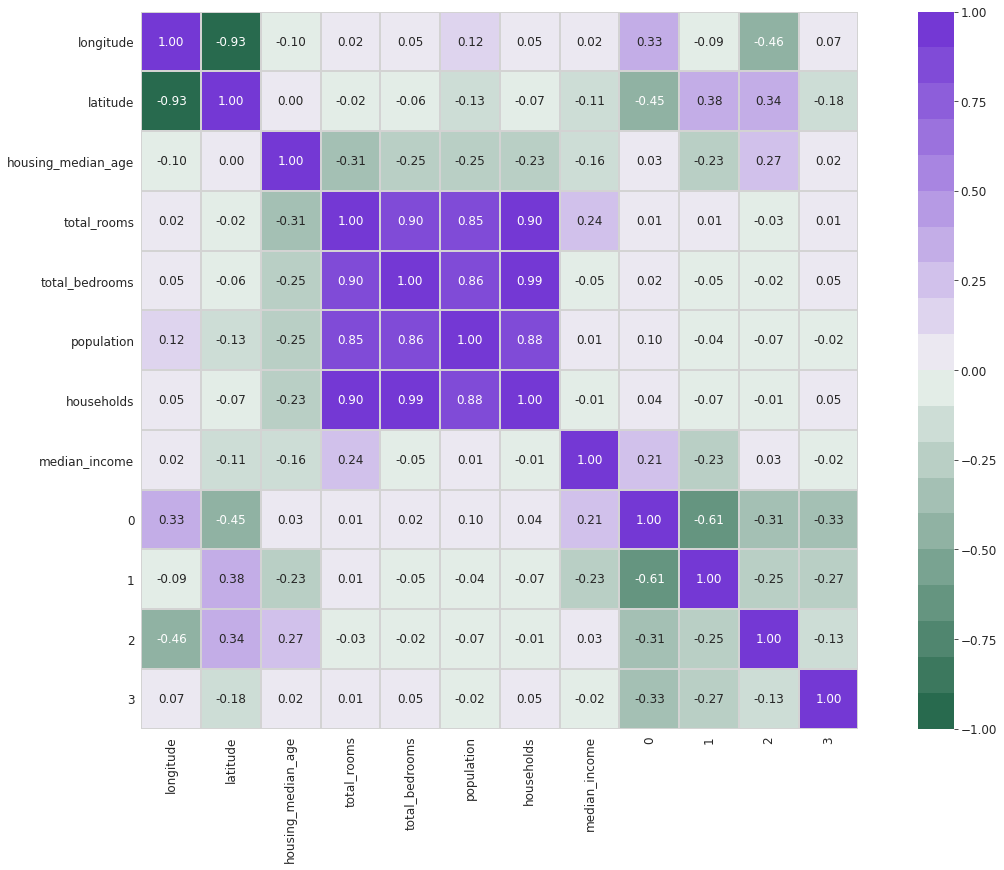

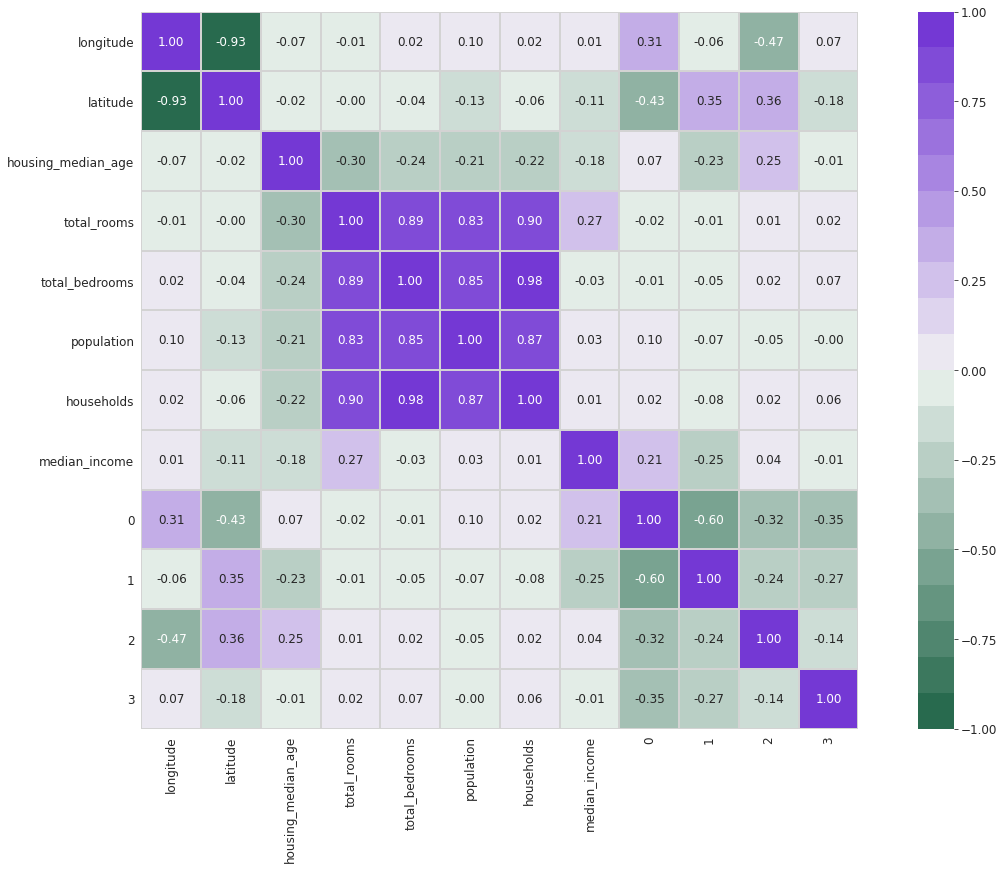

In [217]:
train_notTransf, data_train_notTransf = finalizacionDeProcesamiento_notTransf(train,data_processed,'train')
test_notTransf, data_test_notTransf = finalizacionDeProcesamiento_notTransf(test,data_processed_test,'test')

In [218]:
def finalizacionDeProcesamiento_drop(data_prepared, df_extra_attr,split):
    combined_data=np.c_[df_extra_attr.iloc[:, 0:2], data_prepared].copy() 

    names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
           'total_bedrooms', 'population', 'households', 'median_income',
            'rooms_per_household','population_per_household', 'bedrooms_per_room']
    namesToDrop = [ 'households', 'total_rooms', 'total_bedrooms','population_per_household']

    data_corr = pd.DataFrame(
        combined_data,
        columns=list(names)+["0", "1", "2", "3"],#, "4"],
        index=df_extra_attr.index).astype(float).drop(namesToDrop, axis=1).copy()

    corr_matrix_pr = data_corr.corr()
    paleta = sns.diverging_palette(150, 275, s=80, l=40, n=20)
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(17, 12))
        ax = sns.heatmap(corr_matrix_pr,
                         annot=True,
                         annot_kws={'size': 12},
                         fmt='.2f',
                         vmax=1, 
                         vmin=-1, 
                         square=True, 
                         linewidths=.01, 
                         linecolor='lightgray', 
                         cmap=paleta)
        save_fig("correlation_dropped_"+split)
    return combined_data, data_corr

Saving figure correlation_dropped_train
Saving figure correlation_dropped_test


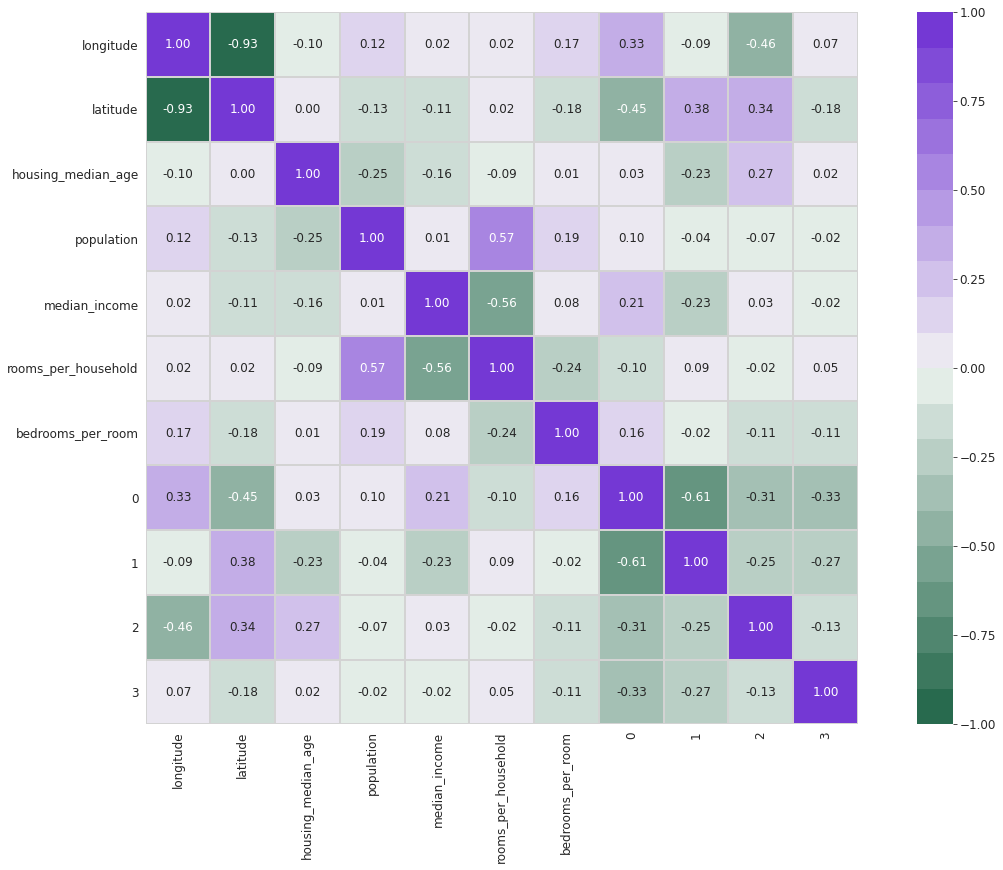

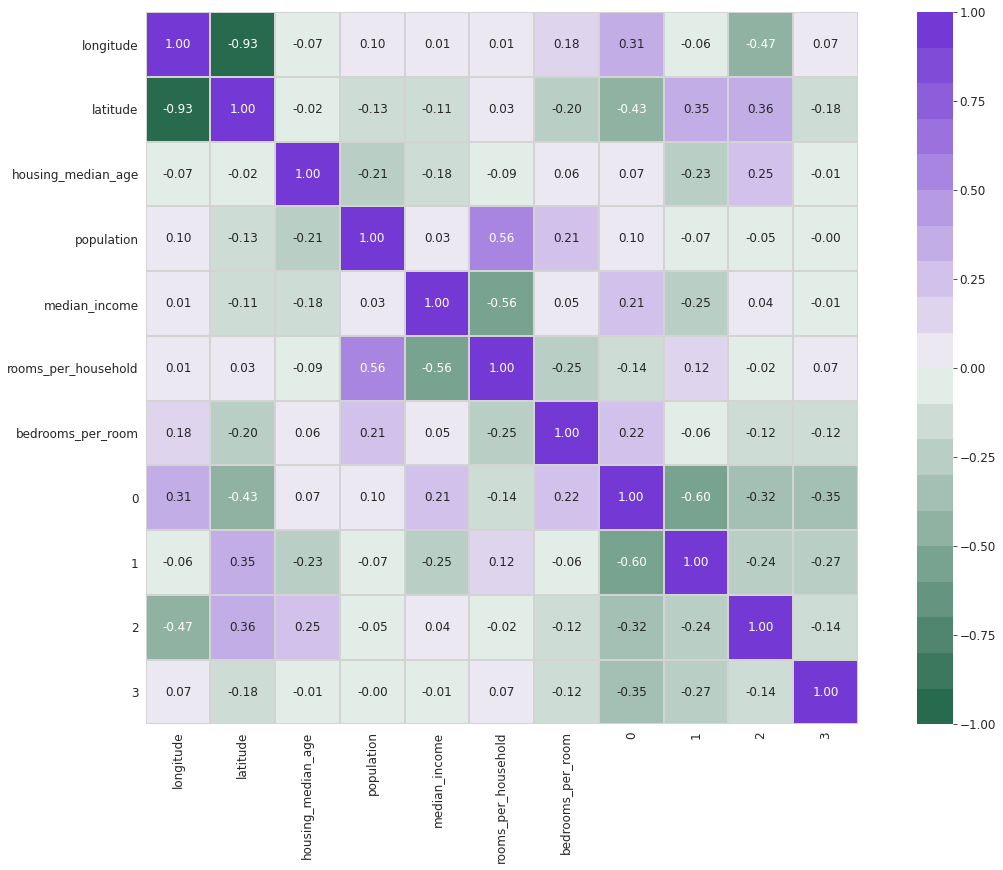

In [219]:
train_dropped, data_train_dropped = finalizacionDeProcesamiento_drop(train,data_processed,'train')
test_dropped, data_test_dropped = finalizacionDeProcesamiento_drop(test,data_processed_test,'test')

## **Entrenamiento de los modelos**

In [220]:
def selectValuesForHyperparameter(initialValue, lastValue, jumps):
    rv = []
    for v in range(int(initialValue*100), int(lastValue*100),int(jumps*100)):
        rv.append(float(v/100));
    return rv 

def models(train, train_labels, test, test_labels):
          
    #LASSO
        
    #búsqueda de hiperpatámetro y training
    maxIt = 5000
    alphaValues = selectValuesForHyperparameter(0.2, 5.1, 0.1)
    l1Values = selectValuesForHyperparameter(0, 1.1, 0.1);  

    lasso_params = {'alpha':alphaValues}
    lasso = linear_model.Lasso(max_iter=maxIt)
    clf_lasso = GridSearchCV(lasso, lasso_params, cv=10,
                                    scoring='neg_mean_squared_error',
                                    return_train_score=True,
                                    refit=True)
    clf_lasso.fit(train, train_labels)
    lasso = clf_lasso.best_estimator_
    
    #test
    housing_predictions_lasso = lasso.predict(test)
    lin_mse_lasso = mean_squared_error(test_labels, housing_predictions_lasso)
    lin_rmse_lasso = np.sqrt(lin_mse_lasso)
    
    #RIDGE
    
    #búsqueda de hiperpatámetro y training
    ridge_params = {'alpha':alphaValues}
    ridge = Ridge(max_iter=maxIt)
    clf_ridge = GridSearchCV(ridge, ridge_params, cv=10,
                                        scoring='neg_mean_squared_error',
                                        return_train_score=True,
                                        refit=True)
    clf_ridge.fit(train, train_labels)
    ridge = clf_ridge.best_estimator_
    
    #test
    housing_predictions_ridge = ridge.predict(test)
    lin_mse_ridge = mean_squared_error(test_labels, housing_predictions_ridge)
    lin_rmse_ridge = np.sqrt(lin_mse_ridge)
        
    #ELASTIC NET
    
    #búsqueda de hiperpatámetro y training
    elastic_params = {'alpha':alphaValues, 'l1_ratio':l1Values}
    elastic = linear_model.ElasticNet(max_iter=maxIt)
    clf_elastic = GridSearchCV(elastic, elastic_params, cv=10,
                                        scoring='neg_mean_squared_error',  
                                        return_train_score=True)
    clf_elastic.fit(train, train_labels)
    elastic = clf_elastic.best_estimator_
    
    #test
    housing_predictions_elastic = elastic.predict(test)
    lin_mse_elastic = mean_squared_error(test_labels, housing_predictions_elastic)
    lin_rmse_elastic = np.sqrt(lin_mse_elastic)
    
    print('El valor del hiperparámetro seleccionado para LASSO es:'+str(clf_lasso.best_params_['alpha'])+'\n')
    print('El valor del hiperparámetro seleccionado para RIDGE es:'+str(clf_ridge.best_params_['alpha'])+'\n')
    print('El valor de los hiperparámetros seleccionados para Elastic Net es: alpha:'+str(clf_elastic.best_params_['alpha'])+', l1:'+str(clf_elastic.best_params_['l1_ratio'])+'\n')
    
    #Comparación de los RMSE para los tres modelos
    print("El RMSE para Lasso es:"+str(lin_rmse_lasso)+'\n')
    print("El RMSE para Ridge es:"+str(lin_rmse_ridge)+'\n')
    print("El RMSE para Elastic Net es:"+str(lin_rmse_elastic)+'\n')
    
    return lin_rmse_lasso, clf_lasso.best_params_['alpha'], lin_rmse_ridge, clf_ridge.best_params_['alpha'], lin_rmse_elastic, clf_elastic.best_params_['alpha'], clf_elastic.best_params_['l1_ratio']

# Resultados y Discusión

In [221]:
# 1
rmse_lasso_1, alp_lasso_1, rmse_ridge_1, alp_ridge_1, rmse_elastic_1, alp_elastic_1, l1_elastic_1 =models(data_train_notTransf, train_labels, data_test_notTransf, test_labels)

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1895461854737.5312, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1886539917647.9336, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899468503465.0938, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:5

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1903102786421.0664, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1879213145153.8047, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1871513412576.8984, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:5

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33847771809140.65, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33507898720867.71, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33566670343598.168, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37756193701503.83, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37457026919585.445, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37464496976595.63, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39212931215237.61, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39067579458555.24, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40194557693264.375, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41080402878186.336, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41060827043040.45, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41138785419956.84, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42192122371506.87, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42344738325991.14, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42479364825077.06, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43529707084643.27, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43209046247942.266, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43273256718040.3, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44818167148137.56, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44374289204948.45, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44387530069822.11, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45018863701105.3, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44804264755719.64, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45531158077427.1, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: 

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45504709015461.29, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45526217395497.63, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45644891449607.35, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45747797243552.14, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45897258143533.73, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46020241798461.57, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46442916889860.59, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46120851546718.24, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46189081520825.99, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47304554390843.08, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46811269365112.016, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46823462449724.69, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47235297090470.055, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46992403621335.01, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47643306103682.984, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:5

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47366039348695.43, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47408823353635.32, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47544565252465.55, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47369387402234.77, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47520834155747.47, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47633878286478.164, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47862967736184.12, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47537813306933.79, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47609286593293.15, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48585831430006.62, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48068052194274.01, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48078162543700.19, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

El valor del hiperparámetro seleccionado para LASSO es:0.3

El valor del hiperparámetro seleccionado para RIDGE es:3.4

El valor de los hiperparámetros seleccionados para Elastic Net es: alpha:0.3, l1:1.0

El RMSE para Lasso es:56954.53503364549

El RMSE para Ridge es:56956.77524780586

El RMSE para Elastic Net es:56954.53503364549



In [222]:
# 2
rmse_lasso_2, alp_lasso_2, rmse_ridge_2, alp_ridge_2, rmse_elastic_2, alp_elastic_2, l1_elastic_2=models(train_transf, train_labels, test_transf, test_labels)

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1871203493922.1914, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1861614321835.9492, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1869655954995.1719, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:5

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1877677664293.4727, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1852934159894.711, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1846517843139.539, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31637976284902.03, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31407138408467.832, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31407662638127.438, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35524179809856.7, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35238615185086.81, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35190954505274.97, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: 

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37006492793692.45, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36909139327113.266, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38014376715893.73, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38953217474384.87, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38936042077728.59, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39025520159155.03, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40189510626869.65, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40384093024798.27, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40463482184619.08, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41627366569449.04, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41352930569221.086, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41383176261178.914, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43030677005909.29, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42614314224057.26, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42596013104704.19, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43307863171431.19, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43126869091174.36, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43843642823648.945, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43871863985458.31, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43896616728143.6, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44028866719782.56, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: 

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44213001270762.63, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44400504602738.54, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44473997730181.01, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44985478828275.24, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44688761774916.02, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44732991977287.13, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45917037467660.086, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45448790341136.54, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45439024572411.516, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45901930683087.97, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45683863051306.77, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46321753403691.055, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46077769491294.87, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46124945715814.58, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46273284820866.984, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46148150598704.81, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46333030500394.22, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46402632747700.71, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46696432732637.77, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46387341082835.45, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46440213580583.37, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47462891193766.766, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46966908052016.85, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46960160098026.84, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

El valor del hiperparámetro seleccionado para LASSO es:0.3

El valor del hiperparámetro seleccionado para RIDGE es:1.6

El valor de los hiperparámetros seleccionados para Elastic Net es: alpha:0.3, l1:1.0

El RMSE para Lasso es:56302.87965315433

El RMSE para Ridge es:56305.220193383444

El RMSE para Elastic Net es:56302.87965315433



In [223]:
# 3 Dropped
rmse_lasso_3, alp_lasso_3, rmse_ridge_3, alp_ridge_3, rmse_elastic_3, alp_elastic_3, l1_elastic_3=models(data_train_dropped, train_labels, data_test_dropped, test_labels)

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1910447745359.2148, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899399966312.8398, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1903851713735.5156, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:5

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26443396356917.19, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1910447745359.2148, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1899399966312.8398, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:5

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1904668221722.2344, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31245706285997.68, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31042193770695.72, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34032424419458.64, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34072623998043.676, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33989192351790.86, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37156987326001.01, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37212858672576.8, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37215565097230.89, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: 

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39108037940037.06, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39135709467839.2, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39346610502579.11, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41049362193848.63, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41039631192334.59, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40718358410102.266, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41845193438371.28, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42689112167880.76, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42286570312642.33, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42972174839575.77, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43090268723395.03, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42906407969430.7, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43730488958127.875, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43782689905111.2, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43833613372623.74, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44192642830716.02, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44237572676870.98, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44436219243674.57, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45116448969021.0, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45117897097969.72, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44784605971830.32, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: 

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45410312401135.14, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46087453164515.305, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45621434401062.23, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45951350609499.73, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46092005494849.586, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45868423473790.09, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:53

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46229200443090.87, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46282439958556.79, tolerance: 10426848153.13546
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46352105368678.17, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46330963672205.2, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46385197199077.99, tolerance: 10380196085.756763
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46577985850821.95, tolerance: 10415641989.556034
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46973421217852.36, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46976683838368.8, tolerance: 10430538152.21977
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46638941765709.41, tolerance: 10359849228.965088
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: 

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47111817312904.54, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47745707941729.81, tolerance: 10551616175.342741
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47248492491449.8, tolerance: 10435227770.476604
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530:

/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47461100430115.9, tolerance: 10449242400.090187
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47612254363147.484, tolerance: 10485174113.604609
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47367803123497.48, tolerance: 10423259563.194748
  model = cd_fast.enet_coordinate_descent(
/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530

El valor del hiperparámetro seleccionado para LASSO es:0.3

El valor del hiperparámetro seleccionado para RIDGE es:5.0

El valor de los hiperparámetros seleccionados para Elastic Net es: alpha:0.3, l1:1.0

El RMSE para Lasso es:56747.71238632856

El RMSE para Ridge es:56750.36074845781

El RMSE para Elastic Net es:56747.71238632856



/home/bruno/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2111624043948.9023, tolerance: 11595389127.844732
  model = cd_fast.enet_coordinate_descent(


Saving figure comparacion_hiperparametros


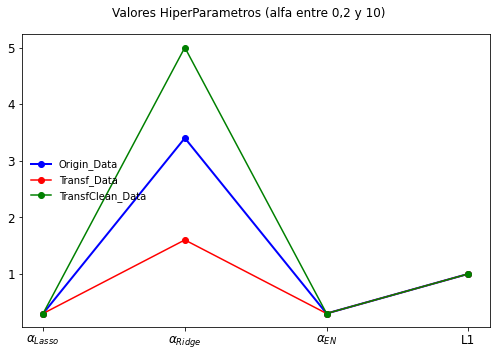

In [224]:
hiperParametros1=[alp_lasso_1, alp_ridge_1,alp_elastic_1,l1_elastic_1]
hiperParametros2=[alp_lasso_2, alp_ridge_2,alp_elastic_2,l1_elastic_2]
hiperParametros3=[alp_lasso_3, alp_ridge_3,alp_elastic_3,l1_elastic_3]
nams=[r'$\alpha_{Lasso}$',r'$\alpha_{Ridge}$',r'$\alpha_{EN}$', 'L1']

plt.figure(figsize=(7, 5))
plt.plot(nams, (hiperParametros1), 'bo-', label='Origin_Data',linewidth=2)#np.log
plt.plot(nams, (hiperParametros2), 'ro-', label='Transf_Data')#np.log
plt.plot(nams, (hiperParametros3), 'go-', label='TransfClean_Data')#np.log
plt.legend(loc='center left', frameon=False)
plt.suptitle('Valores HiperParametros (alfa entre 0,2 y 10)')
#add_value_labels(ax)
save_fig('comparacion_hiperparametros')
plt.show()


Saving figure comparacion_RMSEs


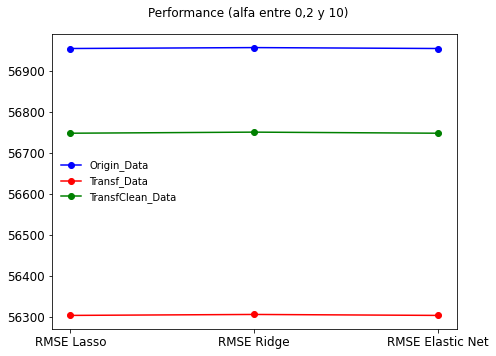

In [225]:
names = ['RMSE Lasso', 'RMSE Ridge', 'RMSE Elastic Net']
values1 = [rmse_lasso_1, rmse_ridge_1, rmse_elastic_1]
values2 = [rmse_lasso_2, rmse_ridge_2, rmse_elastic_2]
values3 = [rmse_lasso_3, rmse_ridge_3, rmse_elastic_3]
plt.figure(figsize=(7, 5))

plt.plot(names, (values1), 'bo-', label='Origin_Data')#np.log
plt.plot(names, (values2), 'ro-', label='Transf_Data')#np.log
plt.plot(names, (values3), 'go-', label='TransfClean_Data')#np.log
plt.legend(loc='center left', frameon=False)
plt.suptitle('Performance (alfa entre 0,2 y 10)')
save_fig('comparacion_RMSEs')
plt.show()

Saving figure comparacion_RMSEs_paraCadaModelo


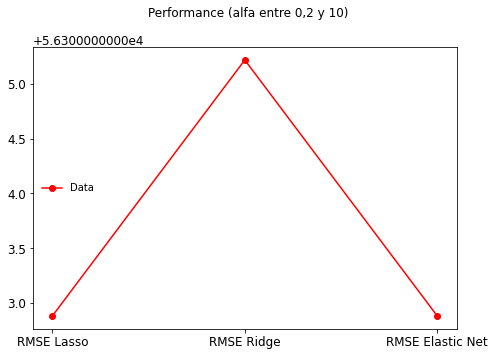

In [226]:
names = ['RMSE Lasso', 'RMSE Ridge', 'RMSE Elastic Net']
values2 = [rmse_lasso_2, rmse_ridge_2, rmse_elastic_2]
plt.figure(figsize=(7, 5))

plt.plot(names, (values2), 'ro-', label='Data')#np.log
plt.legend(loc='center left', frameon=False)
plt.suptitle('Performance (alfa entre 0,2 y 10)')
save_fig('comparacion_RMSEs_paraCadaModelo')
plt.show()

In [39]:
#(alfa entre 5 y 10) PERFORMANCE
values1

[62473.81247153248, 62472.93702176513, 62473.81247153248]

In [40]:
values2

[61843.82241472016, 61841.13515012704, 61843.82241472016]

In [41]:
values3

[62519.64906337676, 62519.19950506685, 62519.64906337676]

In [42]:
hiperParametros1

[2.2, 0.2, 2.2, 1.0]

In [43]:
hiperParametros2

[2.2, 0.2, 2.2, 1.0]

In [44]:
hiperParametros3

[2.2, 0.2, 2.2, 1.0]

In [49]:
#fitear lasso con los parámetros del GridSearch para ver los coeficientes w

lasso = linear_model.LassoCV(alphas=[7.2],
                           max_iter=5000, 
                           cv=10, 
                           random_state=0)
lasso.fit(data_train_dropped, train_labels)

#test
housing_predictions_lasso = lasso.predict(data_test_dropped)
lin_mse_lasso = mean_squared_error(test_labels, housing_predictions_lasso)
lin_rmse_lasso = np.sqrt(lin_mse_lasso)
print('RMSE: ', lin_rmse_lasso)
print('coeficientes: ', lasso.coef_)

RMSE:  62525.59771307814
coeficientes:  [-31802.02443507 -31297.94235161  18840.74494439  -3683.22655293
  85055.24783373   6040.47999814 -28443.19864311      0.
 -33950.76742877  94268.80343923  -8385.55092361    251.48300535]


Se compararon los tres modelos lineales con tres selecciones de variables distintas:
1) Features originales.

2) Features originales + nuevas features calculadas a partir de 4 de las originales. 

3) Una selección acotada de features originales y seleccionando sólo una de los nuevos atributos. 

Observamos que los valores más pequeños de RMSE se obtuvieron para el data-set con los atributos transformados (2). Comparando los valores de los RMSE obtenidos para los tres modelos, el mejor resultó ser LASSO para las tres selecciones de atributos que se utilizaron.